In [108]:
from numpy import pi
import numpy as np
import matplotlib.pyplot as plt
import plotly
import pandas as pd
import math
import padasip as pa

In [109]:
def representsInt(s):
    try: 
        int(s)
        return True
    except ValueError:
        return False
    
def getTableDiameters(_data_frame):     
    return _data_frame.srednica.unique()

def getAvailableDiameterValuesForThreshold(_df, _lookup_diameter_value, _diameter_section_threshold):
    table_diameters = getTableDiameters(_df)
    max_diameters_index = len(table_diameters)
    lookup_diameter_index = table_diameters.tolist().index(_lookup_diameter_value)
      
    if lookup_diameter_index - _diameter_section_threshold < 0:
        left_index = 0
    else:
        left_index = lookup_diameter_index - _diameter_section_threshold
    if lookup_diameter_index + _diameter_section_threshold > max_diameters_index:
        right_index = max_diameters_index  
    else: 
        right_index = lookup_diameter_index + _diameter_section_threshold
    
    return table_diameters[left_index:right_index+1]

In [110]:
def loadTablesFromFile(_tables_urls):
    _tables_df = pd.DataFrame( columns = merged_table_cols, dtype=float)
    
    for table_url in _tables_urls:
        file_df = pd.read_csv(table_url, sep='\t', header=0)
        
        file_df = file_df.drop([0,1])
        file_df = file_df.replace(',','.', regex=True)
        
        parsed_table_df =parseInputTable(file_df)
        
        _tables_df = _tables_df.append(parsed_table_df, ignore_index=True)
    
    _tables_df = _tables_df.sort_values(by=['srednica'])
    
    return _tables_df

In [111]:
def parseInputTable(_input_df):
    out_df = pd.DataFrame( columns = merged_table_cols, dtype=float)
    
    slope_index = 0
    diameters_quantity = int((_input_df.columns.size-1)/2)
    df_rows_quantity = _input_df.shape[0]
    for curr_diameter_index in range(1, diameters_quantity+1):
        Q_index = 2 * curr_diameter_index -1
        v_index = 2 * curr_diameter_index
        curr_diameter = int(_input_df.columns[v_index])
        #print(Q_index,' ', v_index)
        #print(_input_df.columns[v_index])
        curr_diameter_properties = _input_df[[ _input_df.columns[slope_index], _input_df.columns[Q_index], _input_df.columns[v_index]] ].assign( srednica = [curr_diameter] * df_rows_quantity)
        curr_diameter_properties.columns = out_df.columns
        out_df = out_df.append(curr_diameter_properties, ignore_index=True)
    
    out_df.spadek = out_df.spadek.astype(float)
    out_df.Q = out_df.Q.astype(float)
    out_df.v = out_df.v.astype(float)
    out_df.srednica = out_df.srednica.astype(float)
    
    return out_df

In [143]:
def getDiameterEntriesForQ(_diameters_table, _lookup_v_max_value, _diameter_threshold_sections, 
                     _lookup_Q_value, _Q_threshold_value, _lookup_diameter_values):
    """Filters diameters table for appropriate diameters and slope ('spadek')."""
    # filter by v
    filtered_df = _diameters_table[ _diameters_table.v < _lookup_v_max_value]
    
    # filter by Q
    filtered_df = filtered_df[ filtered_df.Q.subtract(_Q_threshold_value) <= _lookup_Q_value]
    filtered_df = filtered_df[ filtered_df.Q.add(_Q_threshold_value) >= _lookup_Q_value]
    
    # filter by diameter - srednica
    if _lookup_diameter_values[0] == -1:
        available_diameter_values = getTableDiameters(_diameters_table)
    else:
        available_diameter_values = _lookup_diameter_values
    filtered_df = filtered_df[ filtered_df.srednica >= available_diameter_values[0]]
    filtered_df = filtered_df[ filtered_df.srednica <= available_diameter_values[-1]]
    
    return filtered_df

In [144]:
# Get all sections in scheme for node. Used only by getSectionsInSchemes.
def getSectionsInSet(_df, _node):
    prefix_name = _node + '-'
    suffix_name = '-' + _node

    return _df[ _df.name.str.startswith(prefix_name) | _df.name.str.endswith(suffix_name)]

# Get all sections in all schemes for node.
def getSectionsInSchemes(_pipes, _node):
    out_df = pd.DataFrame(columns=_pipes[0].columns, dtype=float)
    
    for pipe_set in _pipes:
        sections = getSectionsInSet(pipe_set, _node)
        out_df = out_df.append(sections, ignore_index=True)
    return out_df

# Get section instances in all schemes for name.
def getSection(_pipes, _section_name):
    _node = _section_name[ :_section_name.find('-')]
    out_df = pd.DataFrame(columns=_pipes[0].columns, dtype=float)
    
    for pipe_set in _pipes:
        section = pipe_set[ pipe_set.name == _section_name]
        out_df = out_df.append(section, ignore_index=True)
    return out_df

In [145]:
# Find diameters for sections including diameter value and Q threshold value.
def getDiametersForSections(_sections, _Q_threshold_value, _lookup_diameter_value):
    common_diameters = pd.DataFrame(columns=tables_df.columns, dtype=float)
    for section in _sections.iterrows():
        Q_obl_value = section[-1].Q1_obl
        found_diameters = getDiametersForQ(tables_df, 2, 2, abs(Q_obl_value), _Q_threshold_value, _lookup_diameter_value)
        common_diameters = common_diameters.append(found_diameters)    
    
    common_diameters.sort_values(by=['Q','srednica'], inplace=True)
    common_diameters = common_diameters.drop_duplicates()
    
    return common_diameters

In [146]:
def fitDiametersToAdjacentPipes(_tables_df, _adjacent_diameters):
    """ It is assumed that "dymensja" has value of 2.
    Returns available diameters of pipes that can be connected with '_adjacent_diameters' pipes. """
    if len(_adjacent_diameters) == 0:
        return ['error!']
    
    if len(_adjacent_diameters) == 1:
        return getAvailableDiameterValuesForThreshold(_tables_df, _adjacent_diameters[0], 2)
    
    if len(_adjacent_diameters) >= 3:
        return _adjacent_diameters
    
    table_diameters = getTableDiameters(_tables_df)
    if len(_adjacent_diameters) == 2:
        leftSideD = getAvailableDiameterValuesForThreshold(_tables_df, _adjacent_diameters[0], 2)
        righSideD = getAvailableDiameterValuesForThreshold(_tables_df, _adjacent_diameters[1], 2)
        
        merged_D = np.append(leftSideD, righSideD)
        unq, count = np.unique(merged_D, axis=0, return_counts=True)
        return unq[count > 1]
    
def getAdjacentDiametersToSection(_pipes, _section_name):
    nodes_in_section = _section_name.split('-')
    adjacent_diameters = []
    
    for node in nodes_in_section:
        sections = getSectionsInSchemes(pipes, node)
        adjacent_diameters = np.append(adjacent_diameters,sections.srednica)
    
    adjacent_diameters = list(set(adjacent_diameters))
    if 0 in adjacent_diameters:
        adjacent_diameters.remove(0)
    
    return adjacent_diameters

In [147]:
def applyDiameterEntryToSection(_pipes, _section_name,_diameter_entry):
    for pipi in _pipes:
        section_row_index = pipi[ pipi.name == _section_name].index
        pipi.at[section_row_index,'srednica'] =  _diameter_entry.srednica
        pipi.at[section_row_index,'spadek'] =  _diameter_entry.spadek
        pipi.at[section_row_index,'v'] =  _diameter_entry.v
        pipi.at[section_row_index,'dH'] = (pipi['L'][section_row_index] * pipi['spadek'][section_row_index])/1000
        
def calculateSchemeResults(_pipes):
    ''' Calculate sum of dH and returns:
     dataFrame: columns = ['scheme', 'ring', 'sum_dH'] and quadratic error of all three values
     where reference value equals 0.'''
    quadratic_error_reference_point = 0
    results = pd.DataFrame(columns = ['scheme', 'ring', 'sum_dH'])
    i = 0
    
    for j in range(0,3):
        pipi = pipes[j]
        if j == 0:
            scheme_name = 'Q_min'
        elif j == 1:
            scheme_name = 'Q_max'
        else:
            scheme_name = 'Q_poz'
            
        sections_ring_1 = pipi[ pipi.ring == 1.0]
        sections_ring_2 = pipi[ pipi.ring == 2.0]
        
        sum_dH_1 = sum(sections_ring_1.dH)
        sum_dH_2 = sum(sections_ring_2.dH)
     
        results.loc[i] = [scheme_name, 1, sum_dH_1]
        results.loc[i+1] = [scheme_name, 2, sum_dH_2]
        i+=2
        
    sum_dH_quadratic_error =  sum(results.sum_dH- quadratic_error_reference_point)/len(results)
    return results, sum_dH_quadratic_error

In [148]:
merged_table_cols = ['spadek', 'Q', 'v', 'srednica']
tables_urls = [
    "table_data 1.1.csv",
    "table_data 1.2.csv",
    "table_data 1.4.csv",
    "table_data 1.5.csv",
]

tables_df = loadTablesFromFile(tables_urls)
set(tables_df.srednica)
tables_df

,spadek,Q,v,srednica
0,0.2,0.7,0.09,100.0
289,5.5,3.9,0.50,100.0
290,6.0,4.1,0.52,100.0
291,6.5,4.2,0.54,100.0
292,7.0,4.4,0.56,100.0
...,...,...,...,...
283,4.0,1131.0,1.78,900.0
284,4.2,1159.0,1.82,900.0
285,4.4,1187.0,1.87,900.0
275,2.4,876.0,1.38,900.0


In [196]:
# function: select list of diameters for provided Q - DONE
## Assign available diameter for entry
def initPipes():    
    pipes_start_cols = ["name","ring", "L", "q", "Qp", "Qk", "direction"]
    
    pipes_poz = pd.DataFrame(columns = pipes_start_cols, dtype=float)
    pipes_poz.loc[0] =  ["W2-W3",   1,  411,  12.7,  359,   346.3,  1]   
    pipes_poz.loc[1] =  ["W3-W4",   1,  333,  10.6,  319.9, 309.3,  1]   
    pipes_poz.loc[2] =  ["W4-W5",   1,  709,  24.3,  309.3, 285,    1]   
    pipes_poz.loc[3] =  ["W5-W6",   1,  1271, 105.7, 120.7, 15,     1] 
    pipes_poz.loc[4] =  ["W2-W8",   1,  494,  18.2,  305.4, 287.2, -1] 
    pipes_poz.loc[5] =  ["W8-W7",   1,  1891, 162,   287.2, 125.2, -1] 
    pipes_poz.loc[6] =  ["W7-W6",   1,  717,  64.1,  125.2, 61.1,  -1]  
    pipes_poz.loc[7] =  ["W5-W9",   2,  1313, 75.3,  164.3, 89,     1]
    pipes_poz.loc[8] =  ["W9-W14",  2,  774,  89,    89,    0,      1]
    pipes_poz.loc[9] =  ["W10-W14", 2,  952,  110,   110,   0,     -1]
    pipes_poz.loc[10] = ["W11-W10", 2,  934,  49.3,  201.1, 151.8, -1]   
    pipes_poz.loc[11] = ["W6-W11",  2,  541,  60.3,  76.1,  15.8,  -1]  
    pipes_poz.loc[12] = ["W5-W6",   2,  1271, 105.7, 120.7, 15,    -1]
    
    pipes_max = pd.DataFrame(columns = pipes_start_cols, dtype=float)
    pipes_max.loc[0] =   [W2-W3,1,411,12.7,332.2,319.5,1] 
    pipes_max.loc[1] =    
    pipes_max.loc[2] =    
    pipes_max.loc[3] =  
    pipes_max.loc[4] =  
    pipes_max.loc[5] =  
    pipes_max.loc[6] =   
    pipes_max.loc[7] =  ["W5-W9",   2,  1313, 75.3,   90,     1]
    pipes_max.loc[8] =  ["W9-W14",  2,  774,  90,     0,      1]
    pipes_max.loc[9] =  ["W10-W14", 2,  952,  109,    0,     -1]
    pipes_max.loc[10] = ["W11-W10", 2,  934,  49.3,   130.8, -1]   
    pipes_max.loc[11] = ["W6-W11",  2,  541,  60.3,   34.8,  -1]  
    pipes_max.loc[12] = ["W5-W6",   2,  1271, 105.7,  7.2,   -1]
    
    pipes_min = pd.DataFrame(columns = pipes_start_cols, dtype=float)
    pipes_min.loc[0] =  ["W2-W3",   1,  411,  7.8,   283.5, 275.5,  1]  # POPRAWIC q male 
    pipes_min.loc[1] =  ["W3-W4",   1,  333,  10.6,  275.5, 268.8,  1]   
    pipes_min.loc[2] =  ["W4-W5",   1,  709,  24.3,  268.8, 253.8,  1]   
    pipes_min.loc[3] =  ["W5-W6",   1,  1271, 105.7, 125,   60,     1] 
    pipes_min.loc[4] =  ["W2-W8",   1,  494,  18.2,  386.7, 375.5, -1] 
    pipes_min.loc[5] =  ["W8-W7",   1,  1891, 162,   375.5, 275.8, -1] 
    pipes_min.loc[6] =  ["W7-W6",   1,  717,  64.1,  275.8, 236.3, -1]  
    pipes_min.loc[7] =  ["W5-W9",   2,  1313, 75.3,  128.8, 46.3,   1]
    pipes_min.loc[8] =  ["W9-W14",  2,  774,  82.5,  82.5,  0,      1]
    pipes_min.loc[9] =  ["W10-W14", 2,  952,  40,    40,    0,     -1]
    pipes_min.loc[10] = ["W11-W10", 2,  934,  49.3,  71.6,  41.3,  -1]   
    pipes_min.loc[11] = ["W6-W11",  2,  541,  60.3,  296.3, 259.2, -1]  
    pipes_min.loc[12] = ["W5-W6",   2,  1271, 105.7, 125,   60,    -1] 
    
    pipes = [pipes_min, pipes_max, pipes_poz]
    
    for pipe_set in pipes:
        pipe_set['0.55*q'] = 0.55 * pipe_set.q
        pipe_set['Q1_obl'] = pipe_set['direction'] *(pipe_set.Qk + pipe_set['0.55*q'])
        pipe_set['srednica'] = 0    
        pipe_set['spadek'] = 0
        pipe_set['v'] = 0
        pipe_set['dH'] = 0
       
    
    #[600,600,600,400,600,600,500,400,300,300,400,500,400]
    # VELOCITY IS INCORRECT
    curr_DE = [
    ["W2-W3",   1.12, 4,     500],
    ["W3-W4",   1.12, 8,     600],
    ["W4-W5",   1.12, 7.5,   600],
    ["W5-W6",   1.12, 2.4,   600],
    ["W2-W8",   1.12, 2.6,   600],
    ["W8-W7",   1.12, 1.8,   600],
    ["W7-W6",   1.12, 8,     500],
    ["W5-W9",   1.12, 1.7,   400],
    ["W9-W14",  1.12, 1.2,   300],
    ["W10-W14", 1.12, 1.2,   300],
    ["W11-W10", 1.12, 1.4,   400],
    ["W6-W11",  1.12, 2.2,   600],
    ["W5-W6",   1.12, 7.5,   400]]
   
    pipes_specs = pd.DataFrame(data=curr_DE, columns = ['section_name', 'v', 'spadek', 'srednica'])
    
    for i in range(0,13):
        curr_row = pipes_specs.loc[i]
        applyDiameterEntryToSection(pipes, curr_row.section_name, curr_row)  
    print('Pipes initialized.')
    return pipes

pipes = initPipes()
# rozne spadki w curr_DE
# automatyczne dobieranie spadku+srednica dla podanego Q

Pipes initialized.


In [191]:
lookup_v_max_value = 2
diameter_threshold_sections = 2
section_name = 'W2-W8' # 'W6-W11' - dobry przyklad ze srednicami

curr_section = getSection(pipes, section_name)
curr_section

,name,ring,L,q,Qp,Qk,direction,0.55*q,Q1_obl,srednica,spadek,v,dH
0,W2-W8,1.0,494.0,18.2,386.7,375.5,-1.0,10.01,-385.51,600.0,2.6,1.12,1.2844
1,W2-W8,1.0,494.0,18.2,332.2,314.0,-1.0,10.01,-324.01,600.0,2.6,1.12,1.2844
2,W2-W8,1.0,494.0,18.2,305.4,287.2,-1.0,10.01,-297.21,600.0,2.6,1.12,1.2844


In [192]:
adjacent_diameters = getAdjacentDiametersToSection(pipes, section_name)
available_diameters_for_section = fitDiametersToAdjacentPipes(tables_df, adjacent_diameters) # Gives available diameters to fit with "dymensja" requirement

print('adjacent_diameters to section  ', section_name,':',adjacent_diameters)
print('available_diameters_for_section', section_name,':',available_diameters_for_section)

adjacent_diameters to section   W2-W8 : [600.0, 500.0]
available_diameters_for_section W2-W8 : [400. 500. 600. 700.]


In [193]:
Q_obl_mean_value = np.abs(curr_section.Q1_obl).mean()
print('Q_obl_mean_value:',Q_obl_mean_value)
lookup_Q_value = 300
lookup_Q_value = Q_obl_mean_value
#Q_threshold_value = 380

lookup_diameter_values = [600]
#lookup_diameter_values = available_diameters_for_section

DE_for_section = getDiameterEntriesForQ(tables_df, lookup_v_max_value, diameter_threshold_sections, lookup_Q_value, Q_threshold_value, lookup_diameter_values)
DE_for_section

Q_obl_mean_value: 335.57666666666665


,spadek,Q,v,srednica
481,5.5,456.0,1.61,600.0
480,5.0,435.0,1.54,600.0
486,8.0,550.0,1.95,600.0
485,7.5,533.0,1.88,600.0
484,7.0,515.0,1.82,600.0
483,6.5,496.0,1.75,600.0
482,6.0,476.0,1.69,600.0
215,4.8,426.0,1.51,600.0
214,4.6,417.0,1.48,600.0
212,4.2,399.0,1.41,600.0


In [194]:
pipes = initPipes()
schemes_begining_results = calculateSchemeResults(pipes)

Q_min1_values = np.array(schemes_begining_results[0].iloc[0].sum_dH)
Q_min2_values = np.array(schemes_begining_results[0].iloc[1].sum_dH)
Q_max1_values = np.array(schemes_begining_results[0].iloc[2].sum_dH)
Q_max2_values = np.array(schemes_begining_results[0].iloc[3].sum_dH)
Q_poz1_values = np.array(schemes_begining_results[0].iloc[4].sum_dH)
Q_poz2_values = np.array(schemes_begining_results[0].iloc[5].sum_dH)

for i in range(0,len(DE_for_section)):
    curr_DE = DE_for_section.iloc[i]
    applyDiameterEntryToSection(pipes, section_name, curr_DE)
    
    results = calculateSchemeResults(pipes)
    #print(results[0])
    Q_min1_values = np.append(Q_min1_values,results[0].iloc[0].sum_dH)
    Q_min2_values = np.append(Q_min2_values,results[0].iloc[1].sum_dH)
    Q_max1_values = np.append(Q_max1_values,results[0].iloc[2].sum_dH)
    Q_max2_values = np.append(Q_max2_values,results[0].iloc[3].sum_dH)
    Q_poz1_values = np.append(Q_poz1_values,results[0].iloc[4].sum_dH)
    Q_poz2_values = np.append(Q_poz2_values,results[0].iloc[5].sum_dH)

Pipes initialized.


In [141]:
pipes = initPipes()
calculateSchemeResults(pipes)

Pipes initialized.


(  scheme ring   sum_dH
 0  Q_min    1  31.2262
 1  Q_min    2  18.6599
 2  Q_max    1  31.2262
 3  Q_max    2  18.6599
 4  Q_poz    1  31.2262
 5  Q_poz    2  18.6599, 24.94305)

In [137]:
#applyDiameterEntryToSection(pipes, curr_row.section_name, curr_row)
pipes[1]
Q_poz2_values
Q_poz1_values
len(Q_min1_values)
x_values

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
       33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
       50, 51, 52, 53, 54, 55])

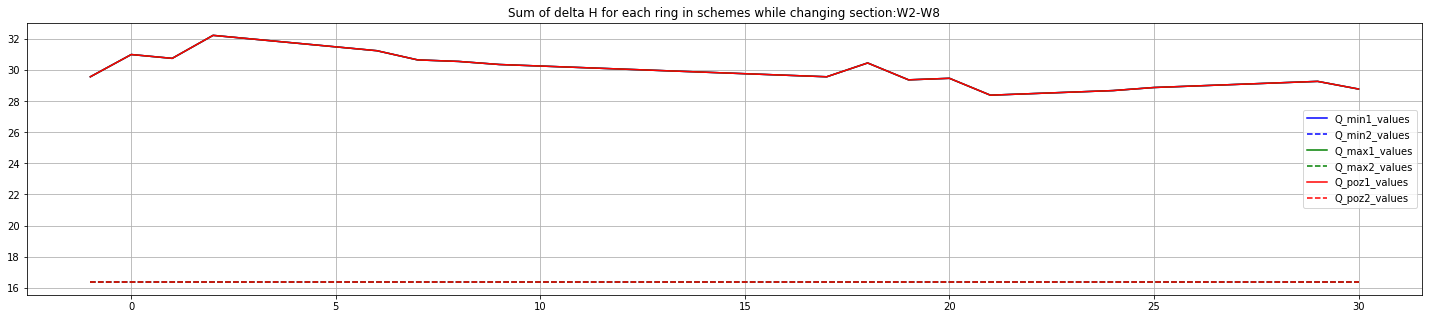

In [195]:
x_values = np.arange(-1, len(DE_for_section),1)
plt.figure(figsize=(25,5))
plt.title('Sum of delta H for each ring in schemes while changing section:' + section_name)
plt.grid()
plt.plot(x_values, Q_min1_values, label = 'Q_min1_values', color='blue',  linestyle='-')
plt.plot(x_values, Q_min2_values, label = 'Q_min2_values', color='blue',  linestyle='--')
plt.plot(x_values, Q_max1_values, label = 'Q_max1_values', color='green', linestyle='-')
plt.plot(x_values, Q_max2_values, label = 'Q_max2_values', color='green', linestyle='--')
plt.plot(x_values, Q_poz1_values, label = 'Q_poz1_values', color='red',   linestyle='-')
plt.plot(x_values, Q_poz2_values, label = 'Q_poz2_values', color='red',   linestyle='--')

plt.legend()

In [ ]:
############################ OLD ########################

In [27]:
# Pokaz srednice dla wybranych odcinkow stykajacych sie z 'W2' uwzgledniajac tylko Q.
# Gdy lookup_diameter_value = -1, to nie jest uwzgledniana srednica narzucona przez pozostale polaczenia.
Q_threshold_value = 20 # odchylenie od Q1_obl podczas szukania srednicy w tablicy.
lookup_diameter_value = -1 # Bo to jest pierwszy wezel - nie ma ograniczen co do srednicy.

diameters_for_W2 = getDiametersForSections(sections, Q_threshold_value, lookup_diameter_value) # obsolete
#diameters_for_W2

In [29]:
diameters_for_W2

section_W2_W3 = getSection(pipes,'W2-W3') # wszystkie 3 wersje dla danego odcinka. 
Q_mean_W2_W3 = section_W2_W3.Q1_obl.mean() # srednia wartosc Q_obl
Q_W2_W3 = 330
section_W2_W3

,name,ring,L,q,Qp,Qk,direction,0.55*q,Q1_obl,srednica,spadek,v,dH
0,W2-W3,1.0,411.0,7.8,283.5,275.5,1.0,4.290,279.790,0.0,0.0,0.0,0.0
1,W2-W3,1.0,411.0,12.7,332.2,319.5,1.0,6.985,326.485,0.0,0.0,0.0,0.0
2,W2-W3,1.0,411.0,12.7,359.0,346.3,1.0,6.985,353.285,0.0,0.0,0.0,0.0


In [35]:
# Wybierz wszystkie pasujace srednice dla odcinka W2-W3 na wszystkich schematach
print(lookup_diameter_value)
diameters_for_W2_W3 = getDiametersForSections(section_W2_W3, Q_threshold_value, lookup_diameter_value)

# Wybierz wiersz z powyzszej listy srednic i zastosuj go 
diameter_W2_W3 = diameters_for_W2_W3.iloc[12] # Arbitralny numer wiersza - 2 stopien swobody

diameter_W2_W3
#diameters_for_W2_W3

-1


spadek        1.20
Q           320.00
v             0.83
srednica    700.00
Name: 221, dtype: float64

In [195]:
      
def findDiameterEntryForSection(_pipes, _section_name, _diameters_to_fit):
    for pipi in _pipes:
        print('13')
    sections = getSectionsInSchemes(pipes,'W2')
#section_names = pipes[0].name.unique()
#
#for section_name in section_names:
#    print(section_name)
    
#applyDiameterEntryToSection(pipes, 'W2-W3', diameter_W2_W3)
#pipes[0]

In [81]:
# MAIN ALGORITHM
adjacent_diameters = getAdjacentDiametersToSection(pipes, 'W3-W4') # Get already set diameters of adjacent pipes.
available_diameters_for_section = fitDiametersToAdjacentPipes(tables_df, adjacent_diameters) # Gives available diameters to fit with "dymensja" requirement

available_diameters_for_section

array([500., 600., 700., 800., 900.])

In [84]:
lookup_v_max_value = 2
diameter_threshold_sections = 2
lookup_Q_value = 350
Q_threshold_value = 20
lookup_diameter_value = -1

getDiametersForQ(tables_df, lookup_v_max_value, diameter_threshold_sections, lookup_Q_value, Q_threshold_value, lookup_diameter_value)

,spadek,Q,v,srednica
464,9.0,361.0,1.84,500.0
463,8.5,350.0,1.79,500.0
462,8.0,340.0,1.73,500.0
209,3.6,369.0,1.31,600.0
208,3.4,359.0,1.27,600.0
207,3.2,348.0,1.23,600.0
206,3.0,337.0,1.19,600.0
223,1.6,369.0,0.96,700.0
222,1.4,345.0,0.90,700.0
265,0.4,358.0,0.56,900.0


In [ ]:
# Po kazdej iteracji niech robi dump w postaci listy tuples: (srednica+spadek) + 3x suma delta H
